#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
#!which python
import sys
sys.executable

'C:\\Users\\moritz\\anaconda3\\envs\\social-2\\python.exe'

# Install dependencies:

In [2]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\moritz\anaconda3\envs\social-2

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pynndescent-0.5.2          |     pyh44b312d_0          43 KB  conda-forge
    umap-learn-0.5.1           |   py36ha15d459_0         123 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         165 KB

The following NEW packages will be INSTALLED:

  pynndescent        conda-forge/noarch::pynndescent-0.5.2-pyh44b312d_0

The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2020.12.5-h5b45459_0
  certifi                anaconda::certifi-2020.6.20-py36_0 --> conda-forge::certifi-2020.12.5-py36ha15d459_1
  openssl     

# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [4]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

Set pandas print options
This will improve readability of printed pandas dataframe.


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [6]:
output_path = "./output/"
model_type = 'DAN' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [7]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [8]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [9]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.39676413
n_clusters: 102 silhouette_avg: 0.33354807
n_clusters: 202 silhouette_avg: 0.343265
n_clusters: 302 silhouette_avg: 0.3551527
n_clusters: 402 silhouette_avg: 0.3698283
n_clusters: 502 silhouette_avg: 0.38568535
n_clusters: 602 silhouette_avg: 0.40777978
n_clusters: 702 silhouette_avg: 0.43281043
n_clusters: 802 silhouette_avg: 0.4516085
n_clusters: 902 silhouette_avg: 0.47913122


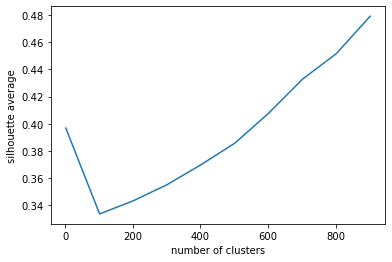

In [10]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [11]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 80     15
44     16
99     18
39     18
67     21
69     22
23     27
70     27
40     28
88     30
18     31
68     32
50     33
96     35
58     38
26     43
74     44
52     45
33     47
51     48
84     49
12     49
27     50
57     50
97     50
75     50
77     51
71     51
28     52
38     54
4      54
79     55
42     57
54     57
94     59
48     60
35     60
6      63
30     64
98     64
89     65
46     65
53     66
59     66
92     67
9      68
81     71
17     72
32     73
83     76
0      78
19     79
62     81
1      81
11     82
21     84
56     84
60     84
16     86
82     89
95     92
7      95
65     97
31     99
29    106
90    107
86    108
76    109
47    112
78    116
93    118
87    121
63    126
37    126
36    127
43    131
45    133
5     135
15    135
73    140
14    143
41    147
64    148
91    151
20    153
3     154
25    165
61    167
72    175
8     183
24    192
10    196
13    213
55    222
22    237
85    248
34    274
49    277
2   

In [12]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [14]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\moritz\anaconda3\envs\social-2\lib\site-packages\umap\umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

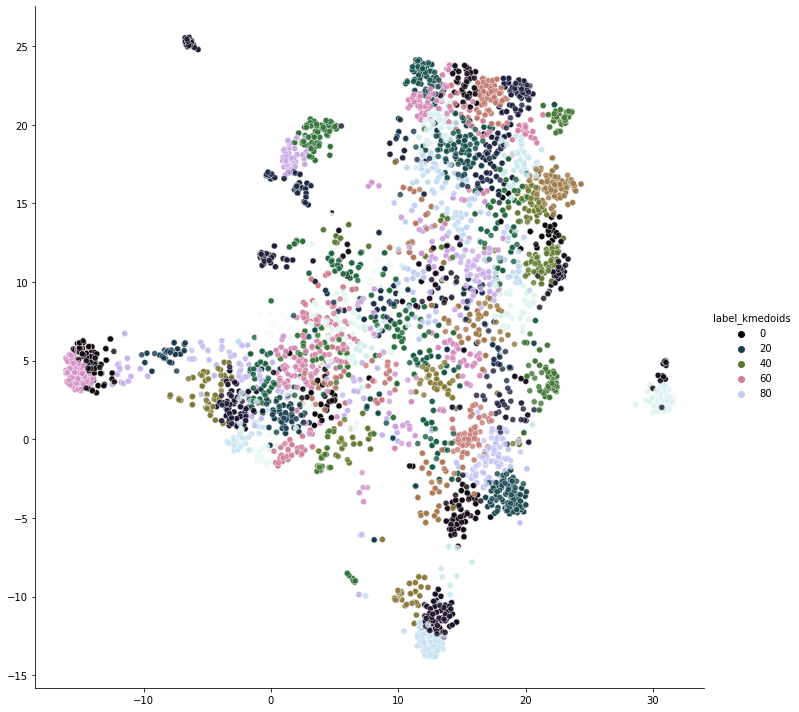

In [15]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "cubehelix" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.80 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

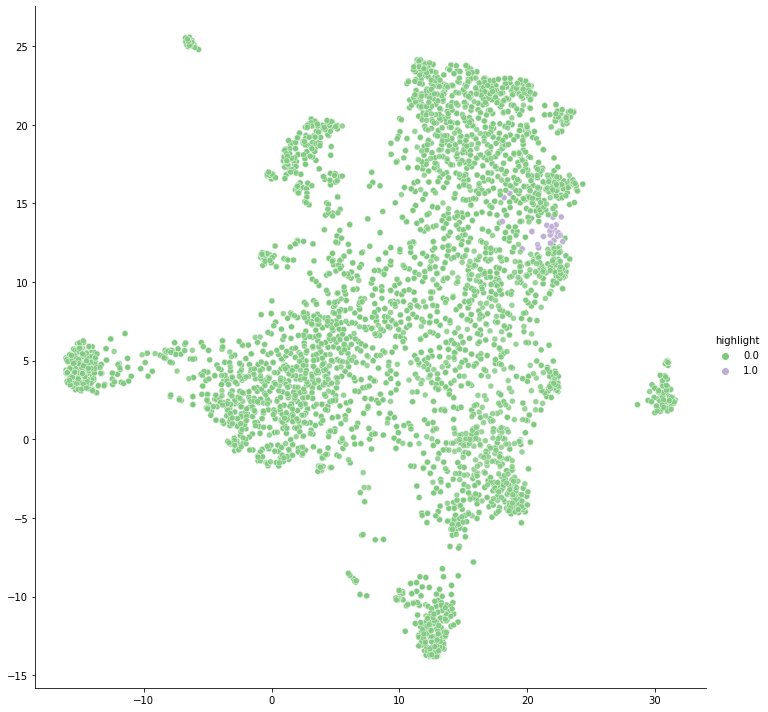

In [16]:
## Choose a cluster to higlight:
cluster_num = 0

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


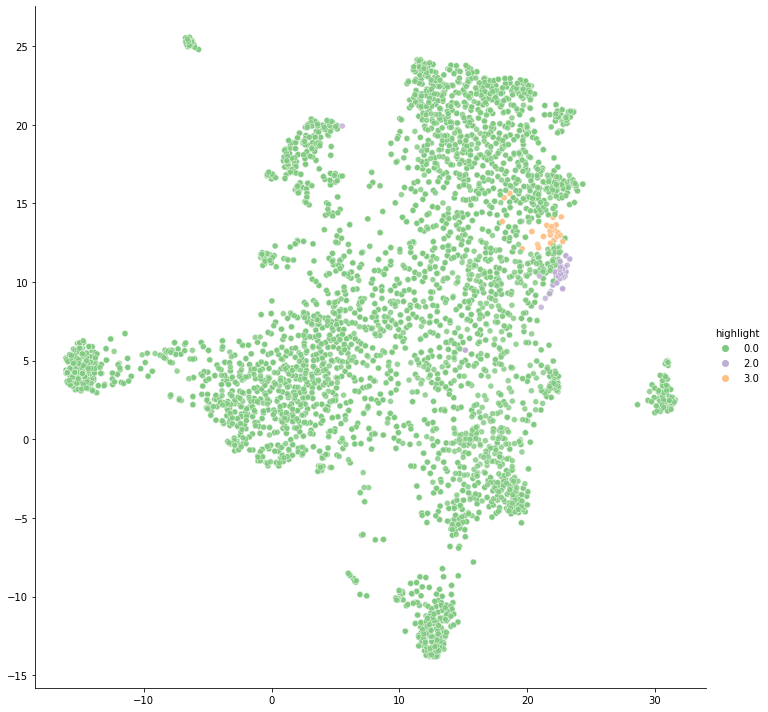

In [17]:
## Choose a cluster to higlight:

data['highlight'] = np.zeros(len(data.index))

data.loc[data['label_kmedoids'] == 7, 'highlight'] = 2
data.loc[data['label_kmedoids'] == 0, 'highlight'] = 3


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

# Print Medoids and cluster statistics

In [18]:
# print the medoids 
data.iloc[medoids_indices]      

Unnamed: 0                    threadId          published_at  \
581          581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
893          893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
589          589  UgyJnsfO1flihxckVoR4AaABAg  2021-01-11T16:42:11Z   
4922        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
5860        2593        UgiHTxbLyqz3QHgCoAEC  2016-04-22T15:16:38Z   
662          662  UgxUXQbbm3iuaoC7y3F4AaABAg  2020-10-30T00:45:07Z   
4441        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
741          741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
2686        1632  UgxTyozHrReLhURuYP54AaABAg  2020-12-15T19:33:39Z   
5952        2685        Ugg25jNZozoE0HgCoAEC  2016-04-22T13:08:43Z   
2610        1556  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-16T15:45:11Z   
5830        2563        UgjWvvIANf9j2ngCoAEC  2016-04-22T15:25:22Z   
9528        3330        Ugghdf83991XwngCoAEC  2017-06-02T14:56:45Z   
715          715  UgzlaBlploJrNXpH_Mt4AaABAg  2020-11-16T04:49:58Z   
9371        3173        Ugi-so97sTbYCHgCoAEC  2017-06-02T15:27:32Z   
380          380  Ugy3aA_6cL65moot6KJ4AaABAg  2020-11-06T07:05:39Z   
9392        3194        Ugg1pEvPlJwZungCoAEC  2017-06-08T07:05:39Z   
2337        1283  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:41:45Z   
5573        2306        UggU2a81kyYfe3gCoAEC  2016-04-23T19:45:20Z   
6064        2797        UgjNy1O68PFesXgCoAEC  2016-04-22T22:56:26Z   
905          905  UgxdQBOEHu6MwKf1jNV4AaABAg  2020-11-10T18:38:45Z   
6962         764  UgyxuyTRvjoUjqTRbwV4AaABAg  2020-10-29T23:21:17Z   
9252        3054        UgguYx_7OqPQxHgCoAEC  2017-06-02T17:31:37Z   
2002         948  Ugxfs-19MnhNvoGinSl4AaABAg  2020-10-30T05:46:41Z   
1047        1047  UgwLMdRMEZXh20LPDTl4AaABAg  2020-10-29T22:26:59Z   
725          725  UgzlaBlploJrNXpH_Mt4AaABAg  2020-10-31T18:32:46Z   
9135        2937  UgwdoPWT1-QR-LM5YFx4AaABAg  2019-09-23T12:13:53Z   
9274        3076        Ugih8m-sM2oV03gCoAEC  2017-06-02T16:33:13Z   
5899        2632        UghiGOPSoQI2cXgCoAEC  2016-04-22T13:50:39Z   
4798        1531  UgyGgyzs9iifS63jnbJ4AaABAg  2020-12-15T20:56:08Z   
987          987  UgyufArHXaCyD0gBfmh4AaABAg  2020-10-29T23:03:21Z   
574          574  UgyewailyJAa_vr2F_54AaABAg  2020-10-30T03:05:49Z   
8768        2570        Ugjprm5-RSIV13gCoAEC  2016-04-22T15:05:23Z   
2508        1454  Ugxg5t6OSGI95y2HZDN4AaABAg  2021-01-08T21:23:51Z   
778          778  UgwKY8gFUUMIWSKUHk54AaABAg  2020-10-29T23:08:12Z   
4887        1620  UgyoFhfC6LFeDGv6GX14AaABAg  2020-12-21T12:59:14Z   
855          855  UgzAokAh4E7qsV_HRax4AaABAg  2020-10-29T22:45:18Z   
412          412  UgwSVdbLtqJDehcAvM54AaABAg  2020-11-11T12:59:22Z   
732          732  UgyOLyseFwo21pl0ye94AaABAg  2021-01-24T16:29:16Z   
8622        2424        Ugi8U-KFM3n2NXgCoAEC  2016-04-22T21:22:35Z   
704          704  UgzM6dEloc-Pp1kgczN4AaABAg  2020-10-30T01:16:45Z   
340          340  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-01T03:52:43Z   
9162        2964        UghcrvtXag4exngCoAEC  2017-06-03T15:36:23Z   
625          625  Ugw5wMbyG6lXhbrf41d4AaABAg  2020-10-31T22:04:13Z   
2598        1544  UgyQ4oIJZqsGTT-vF9R4AaABAg  2020-12-16T00:43:45Z   
5921        2654        Ugi6QLX3-X9C4HgCoAEC  2016-04-22T13:57:44Z   
2656        1602  UgwGOvdPLJaF91sXpqx4AaABAg  2020-12-15T20:48:32Z   
2233        1179  UgxR9OIB4lE2KYU4f7R4AaABAg  2020-12-22T14:14:00Z   
4367        1100  UgzjhsxUn5qXSghnm0x4AaABAg  2021-01-12T02:05:30Z   
441          441  UgzWEL7lmVnn-p6KAS14AaABAg  2020-10-30T10:29:23Z   
2584        1530  UgyGgyzs9iifS63jnbJ4AaABAg  2020-12-15T21:16:21Z   
9191        2993        UghWnZtJokNNgHgCoAEC  2017-06-02T23:30:22Z   
2741        1687  UgzywEG55ypHASSkEpd4AaABAg  2020-12-15T19:04:19Z   
3705         438  UgyWDQurEWP4N8qzsLV4AaABAg  2020-11-02T03:26:30Z   
357          357  UgwDy0uOBXEwUgxD5Nh4AaABAg  2020-10-31T19:00:07Z   
436          436  UgzejX3jqObpiuHNQVB4AaABAg  2020-10-30T10:44:35Z   
9518        3320

In [20]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

KeyError: 'isReply'

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [21]:
# Choose a cluster to print
cluster_number =   1
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 81
Average Distance from cluster center: 1.3579557e-05


Unnamed: 0                    threadId          published_at  \
893          893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
1947         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
7091         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
4160         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
1499         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
445          445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
6643         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
3712         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
3312          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
45            45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
1099          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
6243          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
9317        3119        UgjO_5g-PsvKungCoAEC  2017-06-02T15:56:59Z   
5958        2691        UggUZl_XuU5BKngCoAEC  2016-04-22T13:46:24Z   
8889        2691        UggUZl_XuU5BKngCoAEC  2016-04-22T13:46:24Z   
4818        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
7749        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
2605        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
5378        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
8309        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
3165        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
936          936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
1990         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
7134         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
4203         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
1968         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
7112         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
4181         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
914          914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
8371        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
3227        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
5440        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
8552        2354        UghguaBfxy8M0HgCoAEC  2016-04-23T04:42:00Z   
5621        2354        UghguaBfxy8M0HgCoAEC  2016-04-23T04:42:00Z   
6832         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
1688         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
3901         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
634          634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
1987         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
7131         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
4200         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
933          933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
5993        2726        UghS8GlGYVC_nHgCoAEC  2016-04-22T22:10:24Z   
8924        2726        UghS8GlGYVC_nHgCoAEC  2016-04-22T22:10:24Z   
4577        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
2364        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
7508        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
4113         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
1900         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
846          846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
7044         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
9470        3272        UghDJaHEyrkzlngCoAEC  2017-06-02T18:05:12Z   
5190        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
8121        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
2977        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
8166        1968  UgzNeWVuZbChoEylXBZ4AaABAg  2020-12-15T17:52:52Z   
3022        1968

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [34]:
#which cluster would you like to assign labels to?
cluster_number = 1
#your label
label_manual = '-1'

#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [35]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

Unnamed: 0                    threadId          published_at  \
893          893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
1947         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
7091         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
4160         893  UgzIhjetGoX1ggpjcop4AaABAg  2020-10-29T22:32:24Z   
1499         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
445          445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
6643         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
3712         445  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-10-31T14:15:09Z   
3312          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
45            45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
1099          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
6243          45  UgzXQSVr_r9CjLCtzgN4AaABAg  2020-12-18T03:53:05Z   
9317        3119        UgjO_5g-PsvKungCoAEC  2017-06-02T15:56:59Z   
5958        2691        UggUZl_XuU5BKngCoAEC  2016-04-22T13:46:24Z   
8889        2691        UggUZl_XuU5BKngCoAEC  2016-04-22T13:46:24Z   
4818        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
7749        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
2605        1551  UgwIbeHSaSVBwuxSmQ94AaABAg  2020-12-15T20:30:48Z   
5378        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
8309        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
3165        2111  UgzhpH_OYmY1vedNzbd4AaABAg  2020-12-15T17:49:00Z   
936          936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
1990         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
7134         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
4203         936  Ugzl135VUxIzMSSH8zB4AaABAg  2020-10-29T22:16:22Z   
1968         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
7112         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
4181         914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
914          914  UgzJEJj1bCH8HXyeRed4AaABAg  2020-10-31T05:58:09Z   
8371        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
3227        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
5440        2173  Ugw2sD98mRApStqGRgt4AaABAg  2020-12-15T23:58:46Z   
8552        2354        UghguaBfxy8M0HgCoAEC  2016-04-23T04:42:00Z   
5621        2354        UghguaBfxy8M0HgCoAEC  2016-04-23T04:42:00Z   
6832         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
1688         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
3901         634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
634          634  UgwWDmMcagd7u72VxXZ4AaABAg  2020-10-30T00:58:19Z   
1987         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
7131         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
4200         933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
933          933  UgyWsai2GvUaKWqugwJ4AaABAg  2020-10-29T22:23:02Z   
5993        2726        UghS8GlGYVC_nHgCoAEC  2016-04-22T22:10:24Z   
8924        2726        UghS8GlGYVC_nHgCoAEC  2016-04-22T22:10:24Z   
4577        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
2364        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
7508        1310  UgwUkqc2V5jeUonvjjl4AaABAg  2020-12-17T03:55:18Z   
4113         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
1900         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
846          846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
7044         846  UgyBCbdGHiHAPxTcThh4AaABAg  2020-10-30T05:50:51Z   
9470        3272        UghDJaHEyrkzlngCoAEC  2017-06-02T18:05:12Z   
5190        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
8121        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
2977        1923  UgyVl8zcPjhPeRk87BB4AaABAg  2020-12-15T18:28:58Z   
8166        1968  UgzNeWVuZbChoEylXBZ4AaABAg  2020-12-15T17:52:52Z   
3022        1968

In [24]:
# Choose a cluster to print
cluster_number =   3
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 154
Average Distance from cluster center: 1.1276115e-05


Unnamed: 0                    threadId          published_at  \
2709        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
4922        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
7853        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
7344        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
4413        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
4499        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
2200        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
2286        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
7430        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
4515        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
2302        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
7446        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
8360        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
5429        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
3216        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
5414        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
3201        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
8345        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
9640        3442        Ugj9lbTgvTVATHgCoAEC  2017-06-03T15:49:27Z   
9637        3439        Ugj9lbTgvTVATHgCoAEC  2017-06-03T16:14:11Z   
7429        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
2285        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
3063        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
5276        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
8207        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
4498        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
9516        3318        UgiGSRu29jPTm3gCoAEC  2017-06-04T12:10:36Z   
5430        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
3217        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
8361        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
7990        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
5059        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
2846        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
7746        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
2602        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
4815        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
7445        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
7888        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
4514        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
4957        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
2301        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
2744        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
3125        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
5338        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
8269        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
7443        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
2299        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
4512        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
5352        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
3139        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
8283        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
4541        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
7472        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
2328        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
7680        1482  UgzOQ4rBb5xG0RCMVs54AaABAg  2020-12-15T23:06:50Z   
2536        1482  UgzOQ4rBb5xG0RCMVs54AaABAg  2020-12-15T23:06:50Z   
4749        1482

In [36]:
#which cluster would you like to assign labels to?
cluster_number = 3
#your label
label_manual = '-1'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

Unnamed: 0                    threadId          published_at  \
2709        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
4922        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
7853        1655  Ugxym5a-ByC9gxBlsPd4AaABAg  2020-12-15T20:46:49Z   
7344        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
4413        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
4499        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
2200        1146  Ugyuh4GIdB_bay8nM014AaABAg  2020-12-26T21:34:28Z   
2286        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
7430        1232  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:35:54Z   
4515        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
2302        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
7446        1248  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T12:15:17Z   
8360        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
5429        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
3216        2162  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:41:15Z   
5414        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
3201        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
8345        2147  UgzfrrlAl-SEAHipFbh4AaABAg  2020-12-15T18:39:48Z   
9640        3442        Ugj9lbTgvTVATHgCoAEC  2017-06-03T15:49:27Z   
9637        3439        Ugj9lbTgvTVATHgCoAEC  2017-06-03T16:14:11Z   
7429        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
2285        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
3063        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
5276        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
8207        2009  UgxbQzgcb3TAquyEvw14AaABAg  2020-12-16T15:32:23Z   
4498        1231  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-22T13:39:04Z   
9516        3318        UgiGSRu29jPTm3gCoAEC  2017-06-04T12:10:36Z   
5430        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
3217        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
8361        2163  UgwvG5dGlMEAWzKuP3F4AaABAg  2020-12-15T18:40:14Z   
7990        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
5059        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
2846        1792  Ugyse-7RZ5yRap1WY9B4AaABAg  2020-12-15T18:29:10Z   
7746        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
2602        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
4815        1548  Ugwm14-UauKFnU4ltTF4AaABAg  2020-12-15T20:39:05Z   
7445        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
7888        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
4514        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
4957        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
2301        1247  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:38:20Z   
2744        1690  Ugz9UCjD3NHNNfd3OQx4AaABAg  2020-12-15T23:47:52Z   
3125        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
5338        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
8269        2071  Ugwx1s1vCzdcz98EPV94AaABAg  2020-12-15T17:49:59Z   
7443        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
2299        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
4512        1245  UgzPEf2eCoxUbBsR_RJ4AaABAg  2020-12-20T17:44:30Z   
5352        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
3139        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
8283        2085  UgzVX7OH9Fm_z2FyDkh4AaABAg  2020-12-15T20:18:09Z   
4541        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
7472        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
2328        1274  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-24T03:30:39Z   
7680        1482  UgzOQ4rBb5xG0RCMVs54AaABAg  2020-12-15T23:06:50Z   
2536        1482  UgzOQ4rBb5xG0RCMVs54AaABAg  2020-12-15T23:06:50Z   
4749        1482

In [26]:
# Choose a cluster to print
cluster_number =   6
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 63
Average Distance from cluster center: 2.531589e-05


Unnamed: 0                    threadId          published_at  \
7372        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
2228        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
4441        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
9451        3253        UggvkU2OJ_zRnHgCoAEC  2017-06-02T16:11:38Z   
7509        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
4578        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
2365        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
851          851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
1905         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
7049         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
4118         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
9680        3482        Ugia7a1UTiYrvngCoAEC  2017-06-02T15:25:20Z   
7672        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
4741        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
2528        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
1029        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
7227        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
2083        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
4296        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
9388        3190        Ugg1pEvPlJwZungCoAEC  2017-06-09T01:39:57Z   
1126          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
3339          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
6270          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
72            72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
5049        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
2836        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
7980        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
9395        3197        Ugg1pEvPlJwZungCoAEC  2017-06-07T14:31:46Z   
4773        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
2858        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
5071        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
2560        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
8002        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
7704        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
9444        3246        UggvkU2OJ_zRnHgCoAEC  2017-06-02T23:48:24Z   
8969        2771        UginxVlp9DvZiXgCoAEC  2016-04-22T15:17:36Z   
6038        2771        UginxVlp9DvZiXgCoAEC  2016-04-22T15:17:36Z   
7707        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
4776        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
2563        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
7902        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
4971        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
2758        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
8641        2443        UghDvrO20oWYtHgCoAEC  2016-04-22T20:30:35Z   
5710        2443        UghDvrO20oWYtHgCoAEC  2016-04-22T20:30:35Z   
9439        3241        UggvkU2OJ_zRnHgCoAEC  2017-06-03T07:00:44Z   
9381        3183        Ugg1pEvPlJwZungCoAEC  2017-06-10T08:47:51Z   
2335        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
4548        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
7479        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
5865        2598        Ugj8wz5zn0fsO3gCoAEC  2016-04-22T16:04:27Z   
8796        2598        Ugj8wz5zn0fsO3gCoAEC  2016-04-22T16:04:27Z   
9627        3429        Ugj9lbTgvTVATHgCoAEC  2017-06-06T01:03:33Z   
8898        2700        Ugg4rLzPe_LKe3gCoAEC  2016-04-22T13:29:49Z   
5967        2700        Ugg4rLzPe_LKe3gCoAEC  2016-04-22T13:29:49Z   
9034        2836        UggIzqR4sPGPwXgCoAEC  2016-04-23T11:33:52Z   
6103        2836

In [27]:
#which cluster would you like to assign labels to?
cluster_number = 6
#your label
label_manual = '-1'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

Unnamed: 0                    threadId          published_at  \
7372        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
2228        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
4441        1174  UgykFQfR1WzRtSKGX9d4AaABAg  2020-12-23T21:40:29Z   
9451        3253        UggvkU2OJ_zRnHgCoAEC  2017-06-02T16:11:38Z   
7509        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
4578        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
2365        1311  UgwUkqc2V5jeUonvjjl4AaABAg  2021-01-21T21:42:20Z   
851          851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
1905         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
7049         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
4118         851  UgxHCX3fjV2kvxe-35F4AaABAg  2020-10-29T23:38:25Z   
9680        3482        Ugia7a1UTiYrvngCoAEC  2017-06-02T15:25:20Z   
7672        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
4741        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
2528        1474  UgzNNiQ5L8OnRfW3tW14AaABAg  2020-12-15T23:17:58Z   
1029        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
7227        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
2083        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
4296        1029  UgzCjxrpfVNdl2MCoft4AaABAg  2020-10-29T22:04:48Z   
9388        3190        Ugg1pEvPlJwZungCoAEC  2017-06-09T01:39:57Z   
1126          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
3339          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
6270          72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
72            72  Ugyvc-uWNcjAfJqhXyp4AaABAg  2020-12-13T04:30:58Z   
5049        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
2836        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
7980        1782  UgyrvOqVuzRJFy866E54AaABAg  2020-12-23T22:03:14Z   
9395        3197        Ugg1pEvPlJwZungCoAEC  2017-06-07T14:31:46Z   
4773        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
2858        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
5071        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
2560        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
8002        1804  Ugx8KO-b_VaJA2qpl2t4AaABAg  2020-12-15T22:12:04Z   
7704        1506  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T22:16:59Z   
9444        3246        UggvkU2OJ_zRnHgCoAEC  2017-06-02T23:48:24Z   
8969        2771        UginxVlp9DvZiXgCoAEC  2016-04-22T15:17:36Z   
6038        2771        UginxVlp9DvZiXgCoAEC  2016-04-22T15:17:36Z   
7707        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
4776        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
2563        1509  UgzZa7j-jk8f_kcHFVZ4AaABAg  2020-12-15T21:48:10Z   
7902        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
4971        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
2758        1704  Ugy9em6tmYbbabVU5D94AaABAg  2021-01-18T22:06:03Z   
8641        2443        UghDvrO20oWYtHgCoAEC  2016-04-22T20:30:35Z   
5710        2443        UghDvrO20oWYtHgCoAEC  2016-04-22T20:30:35Z   
9439        3241        UggvkU2OJ_zRnHgCoAEC  2017-06-03T07:00:44Z   
9381        3183        Ugg1pEvPlJwZungCoAEC  2017-06-10T08:47:51Z   
2335        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
4548        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
7479        1281  UgwBKF0UaUHyUrmScKt4AaABAg  2021-01-22T21:46:10Z   
5865        2598        Ugj8wz5zn0fsO3gCoAEC  2016-04-22T16:04:27Z   
8796        2598        Ugj8wz5zn0fsO3gCoAEC  2016-04-22T16:04:27Z   
9627        3429        Ugj9lbTgvTVATHgCoAEC  2017-06-06T01:03:33Z   
8898        2700        Ugg4rLzPe_LKe3gCoAEC  2016-04-22T13:29:49Z   
5967        2700        Ugg4rLzPe_LKe3gCoAEC  2016-04-22T13:29:49Z   
9034        2836        UggIzqR4sPGPwXgCoAEC  2016-04-23T11:33:52Z   
6103        2836

In [28]:
# Choose a cluster to print
cluster_number =   7
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 95
Average Distance from cluster center: 7.0396222e-06


Unnamed: 0                    threadId          published_at  \
1795         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
6939         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
4008         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
741          741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
376          376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
3643         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
6574         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
1430         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
1521         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
467          467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
3734         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
6665         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
5251        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
3038        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
8182        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
6804         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
1660         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
606          606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
3873         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
5261        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
8192        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
3048        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
9549        3351        UgiQ-wCSlwUHZ3gCoAEC  2017-06-02T16:12:37Z   
5253        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
8184        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
3040        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
6453         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
3522         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
255          255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
1309         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
8185        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
3041        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
5254        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
599          599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
6798         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
600          600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
6797         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
1654         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
3867         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
3866         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
1653         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
8326        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
5395        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
3182        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
610          610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
3877         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
1664         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
6808         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
2266        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
7410        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
4479        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
5252        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
3039        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
8183        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
7555        1357  UgztdKn5dUODjIao59F4AaABAg  2020-12-16T15:58:27Z   
2411        1357  UgztdKn5dUODjIao59F4AaABAg  2020-12-16T15:58:27Z   
4624        1357

In [30]:
#which cluster would you like to assign labels to?
cluster_number = 7
#your label
label_manual = '-1'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

Unnamed: 0                    threadId          published_at  \
1795         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
6939         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
4008         741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
741          741  UgwCmiQVCUg9ku_Wr8V4AaABAg  2020-10-29T23:47:53Z   
376          376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
3643         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
6574         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
1430         376  Ugz_K91HmSz8wDdBL0J4AaABAg  2020-10-30T13:17:58Z   
1521         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
467          467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
3734         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
6665         467  UgygqbsTqDTId0bsTkB4AaABAg  2020-10-30T08:40:45Z   
5251        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
3038        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
8182        1984  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T16:56:06Z   
6804         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
1660         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
606          606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
3873         606  UgyJnsfO1flihxckVoR4AaABAg  2020-11-01T03:35:46Z   
5261        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
8192        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
3048        1994  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-16T01:29:37Z   
9549        3351        UgiQ-wCSlwUHZ3gCoAEC  2017-06-02T16:12:37Z   
5253        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
8184        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
3040        1986  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:40:25Z   
6453         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
3522         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
255          255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
1309         255  UgzyTqdUqKBITSHhwT94AaABAg  2020-10-31T02:18:59Z   
8185        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
3041        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
5254        1987  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T03:29:48Z   
599          599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
6798         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
600          600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
6797         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
1654         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
3867         600  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
3866         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
1653         599  UgyJnsfO1flihxckVoR4AaABAg  2020-11-22T11:22:47Z   
8326        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
5395        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
3182        2128  UgynjZA9Ji6dQoOTTgt4AaABAg  2020-12-15T17:48:56Z   
610          610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
3877         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
1664         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
6808         610  UgyqAGlv6AhO3htD95R4AaABAg  2020-10-30T01:56:02Z   
2266        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
7410        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
4479        1212  UgymFwhRbAT8p_oY06d4AaABAg  2020-12-18T21:04:20Z   
5252        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
3039        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
8183        1985  Ugx4ASCRV4i-HIEHAAl4AaABAg  2021-01-24T13:06:25Z   
7555        1357  UgztdKn5dUODjIao59F4AaABAg  2020-12-16T15:58:27Z   
2411        1357  UgztdKn5dUODjIao59F4AaABAg  2020-12-16T15:58:27Z   
4624        1357

In [31]:
# Choose a cluster to print
cluster_number =   0
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 78
Average Distance from cluster center: 1.3354497e-05


Unnamed: 0                    threadId          published_at  \
1635         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
6779         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
3848         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
581          581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
3603         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
6534         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
336          336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
1390         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
3602         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
1389         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
335          335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
6533         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
3614         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
1401         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
347          347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
6545         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
6287          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
1143          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
3356          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
89            89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
8736        2538        Ugj0jG_p9txNuHgCoAEC  2016-04-24T18:29:02Z   
5805        2538        Ugj0jG_p9txNuHgCoAEC  2016-04-24T18:29:02Z   
3269           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
6200           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
2              2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
1056           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
8986        2788        UgiVxZpYEA1U0XgCoAEC  2016-04-22T12:25:43Z   
6055        2788        UgiVxZpYEA1U0XgCoAEC  2016-04-22T12:25:43Z   
8029        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
5098        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
2885        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
3601         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
6532         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
334          334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
1388         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
1310         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
3523         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
256          256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
6454         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
5670        2403        UghI6Ws8YCNejngCoAEC  2016-04-22T22:21:43Z   
8601        2403        UghI6Ws8YCNejngCoAEC  2016-04-22T22:21:43Z   
7781        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
2637        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
4850        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
1498         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
444          444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
3711         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
6642         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
5893        2626        UgjPFI33dyncU3gCoAEC  2016-04-22T14:20:40Z   
8824        2626        UgjPFI33dyncU3gCoAEC  2016-04-22T14:20:40Z   
6535         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
8733        2535        Ugj0jG_p9txNuHgCoAEC  2016-04-22T15:28:14Z   
5802        2535        Ugj0jG_p9txNuHgCoAEC  2016-04-22T15:28:14Z   
1391         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
337          337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
3604         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
9667        3469

In [33]:
#which cluster would you like to assign labels to?
cluster_number = 0
#your label
label_manual = '-1'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

Unnamed: 0                    threadId          published_at  \
1635         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
6779         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
3848         581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
581          581  Ugzy_53XWzGTDeJeTHN4AaABAg  2020-10-30T02:18:47Z   
3603         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
6534         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
336          336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
1390         336  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:20:21Z   
3602         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
1389         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
335          335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
6533         335  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:37:30Z   
3614         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
1401         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
347          347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
6545         347  UgxNN0FxgQCol71vnQt4AaABAg  2020-10-30T15:29:57Z   
6287          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
1143          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
3356          89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
89            89  Ugx5i_5GVLUkj4iqejp4AaABAg  2020-12-13T04:16:01Z   
8736        2538        Ugj0jG_p9txNuHgCoAEC  2016-04-24T18:29:02Z   
5805        2538        Ugj0jG_p9txNuHgCoAEC  2016-04-24T18:29:02Z   
3269           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
6200           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
2              2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
1056           2  UgyLv1kdSZ2B8OhXr5x4AaABAg  2021-01-31T21:46:30Z   
8986        2788        UgiVxZpYEA1U0XgCoAEC  2016-04-22T12:25:43Z   
6055        2788        UgiVxZpYEA1U0XgCoAEC  2016-04-22T12:25:43Z   
8029        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
5098        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
2885        1831  Ugz9Z9N7jlsA4gvSI6h4AaABAg  2020-12-15T18:20:08Z   
3601         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
6532         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
334          334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
1388         334  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:43:49Z   
1310         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
3523         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
256          256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
6454         256  UgzyTqdUqKBITSHhwT94AaABAg  2020-11-02T03:14:10Z   
5670        2403        UghI6Ws8YCNejngCoAEC  2016-04-22T22:21:43Z   
8601        2403        UghI6Ws8YCNejngCoAEC  2016-04-22T22:21:43Z   
7781        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
2637        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
4850        1583  UgyesgtyxDHSUZuICZ14AaABAg  2020-12-16T14:03:05Z   
1498         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
444          444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
3711         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
6642         444  UgzTUdlgJNqbbX_cZ2F4AaABAg  2020-11-12T10:31:28Z   
5893        2626        UgjPFI33dyncU3gCoAEC  2016-04-22T14:20:40Z   
8824        2626        UgjPFI33dyncU3gCoAEC  2016-04-22T14:20:40Z   
6535         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
8733        2535        Ugj0jG_p9txNuHgCoAEC  2016-04-22T15:28:14Z   
5802        2535        Ugj0jG_p9txNuHgCoAEC  2016-04-22T15:28:14Z   
1391         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
337          337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
3604         337  Ugz6_ra14RZnuMLpg9F4AaABAg  2020-11-02T04:15:09Z   
9667        3469